# 価格は適正

今日、商品の価格を推定するためのより複雑なソリューションを構築しています。

1. Day2.0ノートブック：RAG-DB作成
2. Day2.1ノートブック：2Dで視覚化
3. Day2.2ノートブック：3Dで視覚化
4. Day2.3ノートブック：GPT-4o miniでRAGパイプラインを構築してテスト
5. Day2.4ノートブック：(a) ランダムフォレストプライザー (b)アンサンブルプライザーを作成

うーん！それは一日で乗り越えるのにたくさんのことです！

## ご注意ください：

私たちはすでに、独自のファインチューニングされたLLMを使用して非常に強力な製品推定器を持っています。  

ほとんどの人はそれに非常に満足するでしょう！これらの追加の手順を追加する主な理由は、RAGとエージェント・ワークフローで専門知識を深めることです。

## ランダム・フォレストとアンサンブル学習で仕上

In [1]:
# import

# 基本的な
import os
import re
import math
import json
import random
import pickle
import joblib

# HF
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset

# RAG
import chromadb
from sentence_transformers import SentenceTransformer

# LLM
from openai import OpenAI

# 機械学習
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# *.py からの import
from items import Item
from testing import Tester

In [2]:
# .envファイルから環境変数をロード

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [3]:
# Hugging Faceにログイン

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Token has not been saved to git credential helper.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.


In [4]:
# VDBのコレクション
DB = "products_vectorstore"
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

以下のコードは性能的に厳しいので改修
```python
# 埋込ベクトル / メタデータ → 価格
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
#documents = result['documents'] # 不要
prices = [metadata['price'] for metadata in result['metadatas']]
```

In [ ]:
# 以下のようにバッチ分割し、処理時間は15分程度

offset = 0
batch_size = 10000

batch_index = 0
temp_dir = "temp_batches"

# 一時ディレクトリ作成
os.makedirs(temp_dir, exist_ok=True)

# まず総件数を取得（全件は取らない）
total_count = collection.count()

# -----------------------------
# バッチ単位にファイル出力
# -----------------------------
with tqdm(total=total_count, desc="Loading vectors") as pbar:
    while True:
        result = collection.get(
            include=['embeddings', 'metadatas'],
            limit=batch_size,
            offset=offset
        )

        # データが無ければ終了 # 要素数で終了判定
        if len(result['embeddings']) == 0:
            break

        vectors = np.array(result['embeddings'])
        prices = [metadata['price'] for metadata in result['metadatas']]

        # バッチごとにファイル保存
        np.save(os.path.join(temp_dir, f"vectors_{batch_index}.npy"), vectors)
        np.savetxt(os.path.join(temp_dir, f"prices_{batch_index}.txt"), prices, fmt='%s')

        # インクリメント
        batch_index += 1
        offset += batch_size
        # 進捗の更新
        pbar.update(len(vectors))

# ランダム・フォレスト

これで、ランダム・フォレストのモデルを訓練します。第6週との違いを見つけることができますか？

第6週には、Word2Vecでベクトル化しましたが、今回は、Chromaに格納したSentencetransformerでベクトル化したデータ使用します。

M1 Macで1時間と言うが、ローカルで完了しない（未検証だが、オプションを弄ってみるのも良いかも）。

```python
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(vectors, prices)

# rf_modelのテストは、agents.random_forest_agentのテストとして行う。

# agents.random_forest_agentにファイルI/Fで学習済みモデルを渡す
joblib.dump(rf_model, 'random_forest_model.pkl')
```

...ローカルで完了しないので、バッチごと追加学習可能な LightGBM に置き換え、Google Colabで実行する事にした。

In [ ]:
# import

import os
import random
import joblib
import numpy as np

In [ ]:
# Googleドライブをマウントして、トレーニング成果物を保存
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Google Colabで1.5時間ぐらいで完了（LightGBMが高性能なのかparamsが効いているのか未検証）
import lightgbm as lgb
from datetime import datetime

# 必要に応じ設定し直す（再起動時
batch_index = 39
temp_dir = "/content/drive/MyDrive/temp_batches"

# データのログ出力用
def print_limited(value, length=50):
    s = str(value)  # 文字列化
    if len(s) > length: # 指定長さ-3分だけ切って "..." を追加
        s = s[:length - 3] + "..."
    print(s)

# ファイルを読み込みながら返すジェネレータ
def iter_minibatches(batch_index, temp_dir):
    for i in range(batch_index):
        # 説明変数の読み込み
        Xb = np.load(os.path.join(temp_dir, f"vectors_{i}.npy")).astype(np.float32)
        # 目的変数の読み込み
        yb = np.loadtxt(os.path.join(temp_dir, f"prices_{i}.txt"), dtype=np.float32)
        # ログ出力
        print(f"batch_index = {i} のデータロード")
        print_limited(Xb[0]) # データの確認
        # XYを変えす
        yield Xb, yb

params = {
    "objective": "regression",     # 回帰問題
    "metric": "rmse",              # 評価指標
    "learning_rate": 0.02,         # 学習率
    "num_leaves": 128,             # 木の複雑さA
    "max_depth": 15,               # 木の複雑さB
    "feature_fraction": 0.9,       # 列方向サンプリング
    "bagging_fraction": 0.9,       # 行方向サンプリング
    "bagging_freq": 1,             # バギング実行頻度
    "verbosity": -1,               # ログ出力しない
}

counter=0
booster = None
# -----------------------------
# バッチ単位に追加学習
# -----------------------------
for Xb, yb in iter_minibatches(batch_index, temp_dir):
    train_set = lgb.Dataset(Xb, label=yb, free_raw_data=True)
    booster = lgb.train(params, train_set,
        num_boost_round=500,          # バッチごとに追加する木の本数
        init_model=booster,           # 直前までのモデルを継続
        keep_training_booster=True    # 木を追加して継続学習
    )
    counter+=1
    print(f"{counter} 回終了" + datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

In [ ]:
# agents.lightgbm_agentにファイルI/Fで学習済みモデルを渡す
joblib.dump(booster, '/content/drive/MyDrive/'+'lightgbm_model.pkl')

In [ ]:
# 予測（自分で書いたので一応テスト）
batch_vectors = np.load(os.path.join(temp_dir, f"vectors_0.npy"))
y_pred = booster.predict([batch_vectors[0].astype(np.float32)])[0]
y_pred

# アンサンブル・モデル

3つのモデルの推定結果を使用して線形回帰モデルでアンサンブル学習する的な

## アンサンブル学習の準備

In [5]:
# `./agents/xxxx_agent.py`
# ファインチューニングされたLLMを実行するエージェント（Modal上）
from agents.specialist_agent import SpecialistAgent
# Frontier LLM ＋ RAG のエージェント
from agents.frontier_agent import FrontierAgent
# ランダム・フォレスト・モデルのエージェント
#from agents.random_forest_agent import RandomForestAgent
# LightGBMのエージェント
from agents.lightgbm_agent import LightGBMAgent

In [6]:
# 各エージェントの初期化
specialist = SpecialistAgent()
frontier = FrontierAgent(collection)
#random_forest = RandomForestAgent()
lightgbm = LightGBMAgent()

In [7]:
# プロンプトから「商品の説明文」だけを抽出
# ・冒頭の定型文を削除
# ・末端の価格行を削除
def description(item):
    return item.prompt.split("to the nearest dollar?\n\n")[1].split("\n\nPrice is $")[0]

In [8]:
# 埋め込みベクトルからランダム・フォレスト・モデルのエージェントが推定した値を返す
#def rf(item):
#    return random_forest.price(description(item))

# 埋め込みベクトルからLightGBMのエージェントが推定した値を返す
def booster(item):
    return lightgbm.price(description(item))

In [9]:
# test.pklファイルをロード ... 取得手順は、`day2.0_ja.ipynb` を参照の事。

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

1: Guess: $278.85 Truth: $374.41 Error: $95.56 SLE: 0.09 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $253.53 Truth: $225.11 Error: $28.42 SLE: 0.01 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $22.91 Truth: $61.68 Error: $38.77 SLE: 0.93 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $501.63 Truth: $599.99 Error: $98.36 SLE: 0.03 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $47.54 Truth: $16.99 Error: $30.55 SLE: 0.99 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $49.73 Truth: $31.99 Error: $17.74 SLE: 0.19 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $244.89 Truth: $101.79 Error: $143.10 SLE: 0.76 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $395.10 Truth: $289.00 Error: $106.10 SLE: 0.10 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $303.44 Truth: $635.86 Error: $332.42 SLE: 0.54 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $204.76 Truth: $65.99 Error: $138.77 SLE: 1.

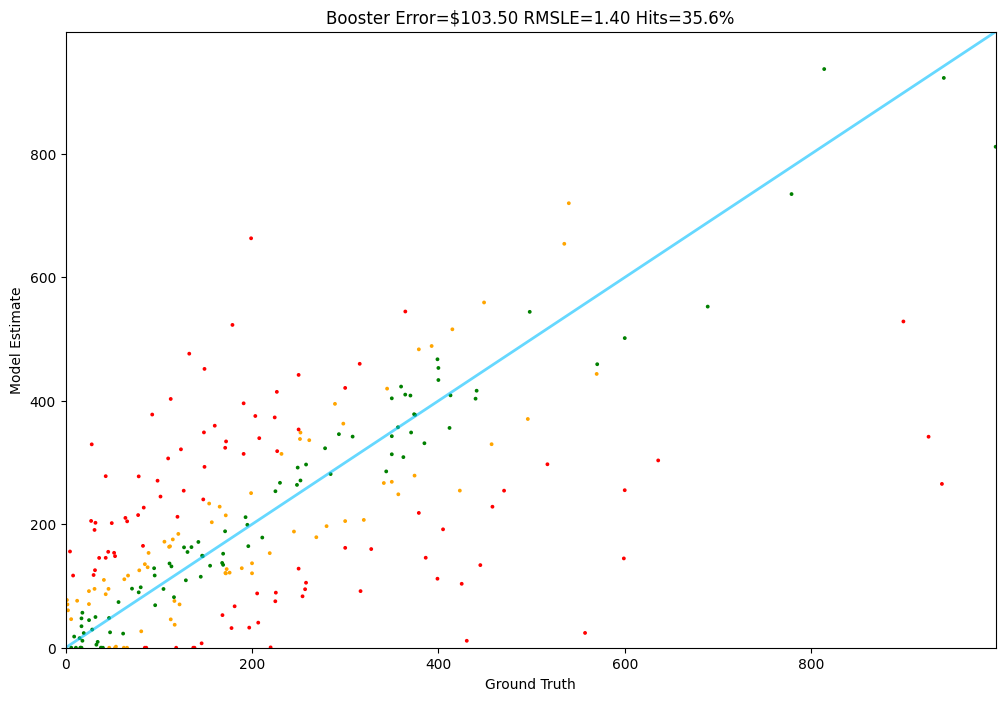

In [10]:
# TestRunnerを実行
#Tester.test(rf, test)      # Error 100$ぐらいらしい
Tester.test(booster, test)  # Error 103$...まぁ及第点

In [ ]:
# 各エージェントの推論を１回、試してみる
product = "Quadcast HyperX condenser mic for high quality audio for podcasting"
print(specialist.price(product))
print(frontier.price(product))
#print(random_forest.price(product))
print(lightgbm.price(product))

## アンサンブル学習の実行

In [ ]:
# 各エージェントでｘ回の推論を実施
specialists = []
frontiers = []
#random_forests = []
lightgbms = []

prices = []
for item in tqdm(test[1000:1250]):
    text = description(item)
    specialists.append(specialist.price(text))
    frontiers.append(frontier.price(text))
    #random_forests.append(random_forest.price(text))
    lightgbms.append(lightgbm.price(text))
    prices.append(item.price)

In [ ]:
# 各データ点ごとに、3モデルの予測値の最小値・最大値を計算。
# 予測結果から派生した特徴量を追加、線形回帰がより柔軟に重み付け可能に。
# 例えば、外れ値を避けるために最小値や最大値が役立つこともある。
mins = [min(s,f,r) for s,f,r in zip(specialists, frontiers, lightgbms)] #random_forests)]
maxes = [max(s,f,r) for s,f,r in zip(specialists, frontiers, lightgbms)] #random_forests)]

# 説明変数 xをDataFrameに変換
X = pd.DataFrame({
    # 3モデルの予測値
    'Specialist': specialists,
    'Frontier': frontiers,
    #'RandomForest': random_forests,
    'LightGBM': lightgbms,
    # 集約特徴量
    'Min': mins,
    'Max': maxes,
})

# 目的変数 yをSeriesに変換
y = pd.Series(prices)

...ローカルで完了しないので、一旦保存し、リスタート後に実行する事にした。

In [ ]:
with open('ensemble_X.pkl', 'wb') as file:
    pickle.dump(X, file)
with open('ensemble_y.pkl', 'wb') as file:
    pickle.dump(y, file)

In [ ]:
# カーネル・リスタート

In [ ]:
with open('ensemble_X.pkl', 'rb') as file:
    X = pickle.load(file)
with open('ensemble_y.pkl', 'rb') as file:
    y = pickle.load(file)

In [ ]:
# 線形回帰を訓練
np.random.seed(42)

lr = LinearRegression()
lr.fit(X, y)

# 各特徴量の回帰係数を表示。係数が大きいほど、その特徴量が予測に強く寄与
feature_columns = X.columns.tolist()
for feature, coef in zip(feature_columns, lr.coef_):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept={lr.intercept_:.2f}")

In [ ]:
# agents.ensemble_agentにファイルI/Fで学習済みモデルを渡す
joblib.dump(lr, 'ensemble_model.pkl')

## アンサンブル・モデルで推定

#### EnsembleAgent

```python
# 各エージェントをまとめるアンサンブル・エージェントの初期化
from agents.ensemble_agent import EnsembleAgent
ensemble = EnsembleAgent(collection)

# 推論の単体テスト
ensemble.price(product)

# 埋め込みベクトルからアンサンブル・モデルが推定した値を返す
def ensemble_pricer(item):
    return max(0,ensemble.price(description(item)))

# TestRunnerを実行
Tester.test(ensemble_pricer, test)
```

#### Ensemble2Agent

In [5]:
# 各エージェントをまとめるアンサンブル・エージェントの初期化
from agents.ensemble2_agent import Ensemble2Agent
ensemble2 = Ensemble2Agent(collection)

In [10]:
# 要再実行
product = "Quadcast HyperX condenser mic for high quality audio for podcasting"
with open('test.pkl', 'rb') as file:
    test = pickle.load(file)
def description(item):
    return item.prompt.split("to the nearest dollar?\n\n")[1].split("\n\nPrice is $")[0]

In [11]:
# 推論の単体テスト
ensemble2.price(product)

200.75863500711307

In [12]:
# 埋め込みベクトルからアンサンブル・モデルが推定した値を返す
def ensemble2_pricer(item):
    return max(0, ensemble2.price(description(item)))

1: Guess: $396.56 Truth: $374.41 Error: $22.15 SLE: 0.00 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $192.48 Truth: $225.11 Error: $32.63 SLE: 0.02 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $45.46 Truth: $61.68 Error: $16.22 SLE: 0.09 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $380.91 Truth: $599.99 Error: $219.08 SLE: 0.21 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $29.25 Truth: $16.99 Error: $12.26 SLE: 0.27 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $27.93 Truth: $31.99 Error: $4.06 SLE: 0.02 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $132.61 Truth: $101.79 Error: $30.82 SLE: 0.07 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $326.96 Truth: $289.00 Error: $37.96 SLE: 0.02 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $932.76 Truth: $635.86 Error: $296.90 SLE: 0.15 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $77.72 Truth: $65.99 Error: $11.73 SLE: 0.03 I

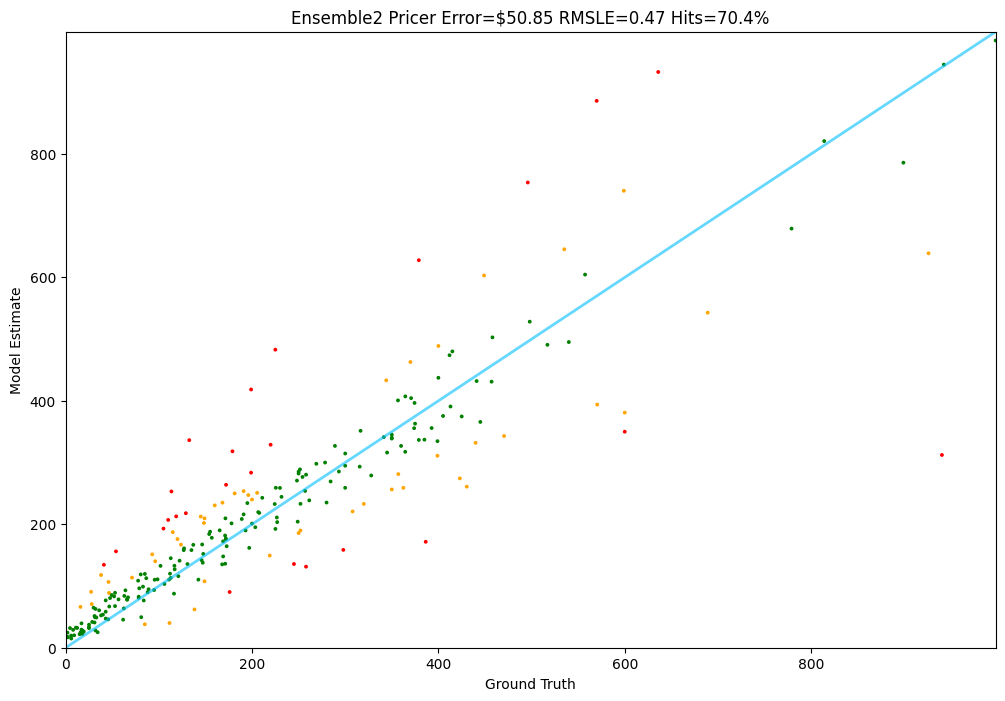

In [13]:
# TestRunnerを実行
Tester.test(ensemble2_pricer, test)

# なんて日だ（笑）

フロンティアモデルのRAGパイプライン、Transformerベースのエンコーディングを使用したランダム・フォレスト・モデル、アンサンブル・モデルなど、多くのことができました。

確かにあなたはもっとうまくやることができます！これをファインチューニングし、コンポーネントをアンサンブルに追加して、パフォーマンスを打ち負かしてみてください。